# TEST DASK CLUSTER

In [17]:
from dask.distributed import Client, SSHCluster
import sys
import dask
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt

from dask import delayed

##  DASK CLUSTER

In [3]:
cluster = SSHCluster(
    ["10.67.22.39", "10.67.22.74", "10.67.22.27", "10.67.22.91", "10.67.22.60"],
    connect_options   = {"known_hosts": "/root/.ssh/known_hosts"},
    worker_options    = {"nthreads": 2, "n_workers": 4},
    scheduler_options = {"dashboard_address": ":8787"}
)

distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.39:46261
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.74:33677'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.74:33895'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.74:35009'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.74:44081'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.91:44961'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 

In [4]:
client = Client(cluster)
client

<Client: 'tcp://10.67.22.39:46261' processes=16 threads=32, memory=62.17 GiB>

## Functions

In [5]:
def load(path):
    return np.load(path, allow_pickle=True)["a"]

@delayed    
def R_yz(theta_rot, phi_rot):
    return np.array([[np.cos(phi_rot) * np.cos(theta_rot), -np.sin(phi_rot) * np.cos(theta_rot), np.sin(theta_rot)], 
                     [np.sin(phi_rot), np.cos(phi_rot), 0], 
                     [-np.sin(theta_rot) * np.cos(phi_rot), np.sin(theta_rot) * np.sin(phi_rot), np.cos(theta_rot)]])

@delayed
def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids  = np.array(conversion_ids["CdID"])
    pmt_ids = np.array(conversion_ids["PMTID"])
    mask    = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

@delayed
def find_pmt_coord(pmt_positions, data_pmt_id):
    return pmt_positions[
        np.isin(pmt_positions.PMTID, data_pmt_id)
        ].loc[:, ['x', 'y', 'z']].reset_index(drop=True).to_numpy()

## Load mapping data

In [6]:
data_folder       = "/root/data/data/real/train/data/"
pmt_pos_fname     = "PMTPos_CD_LPMT.csv"
pmt_id_conv_fname = "PMT_ID_conversion.csv"
train_data_fname  = "raw_data_train_4.npz"

In [7]:
pmt_positions     = pd.read_csv(pmt_pos_fname)
pmt_id_conversion = pd.read_csv(pmt_id_conv_fname)
conversion_ids    = pd.read_csv(pmt_id_conv_fname)

# data should not be loaded yet!
# data = dask.delayed(load)(data_folder+train_data_fname).compute()

## Distributed processing

In [38]:
N_max = 115

def rotate_single_file(fname):

    data_np = load(data_folder+train_data_fname) # dask.delayed(load)(data_folder+train_data_fname).compute()
    Nevents = 50 # data_np.shape[1]
    rotated = []

    for i in range(Nevents):
        # find non-zero-time hits
        data = da.from_array([data_np[:,i][j] for j in range(3)])
        nonzeros_inds = data[2] != 0.0
        data_pmt_id   = convert_pmt_ids(data[0][nonzeros_inds], conversion_ids)
        pmt_coord     = find_pmt_coord(pmt_positions, data_pmt_id)
        
        tot_charge = dask.delayed(sum)(data[1][nonzeros_inds])
        x_cc       = dask.delayed(sum)(pmt_coord[:,0] * data[1][nonzeros_inds]) / tot_charge
        y_cc       = dask.delayed(sum)(pmt_coord[:,1] * data[1][nonzeros_inds]) / tot_charge
        z_cc       = dask.delayed(sum)(pmt_coord[:,2] * data[1][nonzeros_inds]) / tot_charge
        
        theta_cc   = dask.delayed(da.arctan2)(
            dask.delayed(da.sqrt)((x_cc)**2+(y_cc)**2), z_cc
        )
        phi_cc     = dask.delayed(da.arctan2)(y_cc, x_cc) 
        
        theta_rot = -theta_cc + np.pi/2
        phi_rot   = -phi_cc
        
        # coord_new = np.matmul(R_yz(theta_rot, phi_rot), pmt_coord.T)
        coord_new = dask.delayed(da.matmul)(
            R_yz(theta_rot, phi_rot), pmt_coord.T
        )

        R = dask.delayed(da.sqrt)(dask.delayed(da.sum)(dask.delayed(da.power)(coord_new, 2), axis=0))

        charge_hitt = da.vstack([data[1], data[2]])
        charge_hitt = charge_hitt[:,nonzeros_inds]

        rotated.append(dask.delayed(da.vstack)([coord_new, R, charge_hitt]))
        del coord_new
        del charge_hitt
        del pmt_coord
    
    return rotated

def mapping_single_event(rotated_ev):
        ####################
        # rotated_ev must be computed
        ####################
        coord_new   = rotated_ev[0:3, ]
        charge_hitt = rotated_ev[4:, ].T
        R = rotated_ev[3, ].mean()
 
        z_levels, step = da.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
        z_levels       = z_levels.persist()
        image_mat      = da.zeros((230,124,2))

        for j, z in enumerate(z_levels):
            mask = (np.abs(coord_new[2,] - z) < step)         #(np.abs(pmt_pos.z - z) < delta)
            if(not da.any(mask)): continue
            masked = coord_new[:,mask]
            
            
            Rz = (R**2 - z**2)
            if Rz < 0:
                Neff = 0
            else:
                Neff = N_max * da.sqrt(Rz) / R
            #ix = np.zeros(np.sum(mask), dtype=np.int32)
            ix = da.around( Neff * (da.arctan2(masked[1,], masked[0,]) / np.pi) + (N_max / 2) ) + 57
            ix = ix.astype(np.int32)
            #ix = ix.compute()
            if(da.any(ix >= 230)):
                ix[ix >= 230] = ix[ix >= 230] - 230
            
            image_mat[ix, j,] = charge_hitt[mask, ]

            # if np.isnan(mat[ix, i+1]):
            #     mat[ix, i+1] = row.id
            # else:
            #     mat[ix, 123 if i else i] = row.id

        del rotated_ev
        return image_mat
    

### Retreive rotation results

In [39]:
rotated_one_file = rotate_single_file(train_data_fname) # qui dovremo fare un client.map quando mettiamo più files

rotation_future  = client.map(dask.compute, rotated_one_file)

### !!!! ERRORE SUL GATHER
### !!!! INVESTIGATE -> NFS / CLUSTER ISSUES ????

rotated          = client.gather(rotation_future)
persisted_rot    = [rotated[i][0].persist() for i in range(len(rotated))]

#### Plot the rotated event

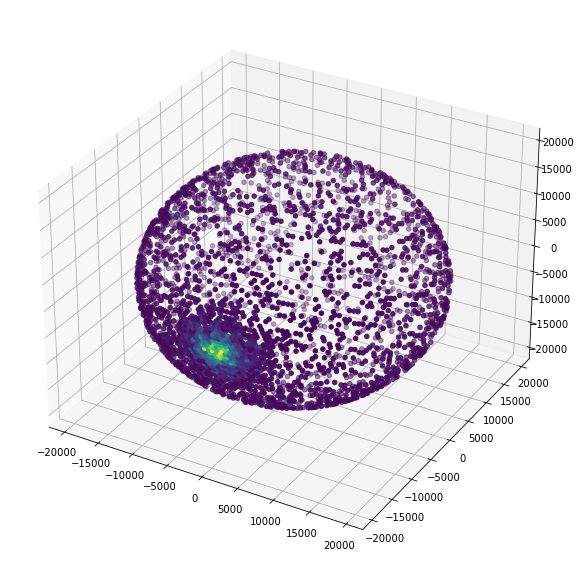

In [50]:
ev = 4
rot = persisted_rot[ev].compute()

fig = plt.figure(figsize=(10,12))
axr = fig.add_subplot(111, projection='3d')

axr.scatter(
    xs = rot[1, :],
    ys = -rot[0, :],
    zs = rot[2, :],
    c  = rot[4, :]
    )

### Retreive mapping results

In [42]:
mapping_future   = client.map(mapping_single_event, persisted_rot)
mapped           = client.gather(mapping_future)
mapped

[dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(230, 124, 2), dtype=float64, chunksize=(230, 124, 2), chunktype=numpy.ndarray>,
 dask.array<setitem, shape=(

In [43]:
mapped_future    = client.map(dask.compute, mapped)
mapped_computed  = client.gather(mapped_future)
mapped_images    = [mapped_computed[i][0] for i in range(len(mapped_computed))]
mapped_images[0].shape

(230, 124, 2)

## PLOT MAPPED EVENT

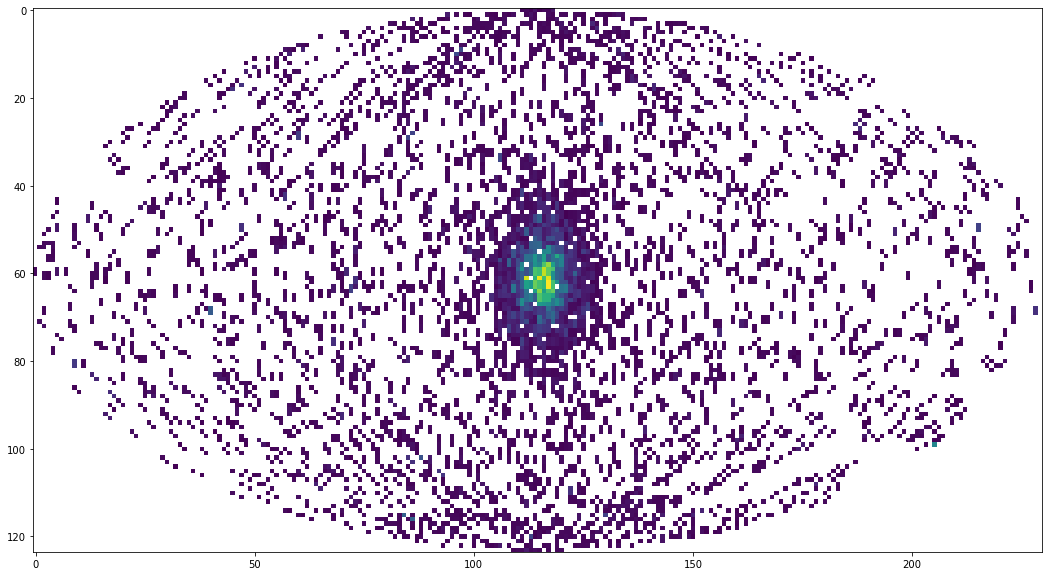

In [45]:
ev = 4

image = mapped_images[ev][:,:,0].T
image[image == 0] = np.NaN

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(image)
plt.show()

# ***Stop Cluster (!)***

In [10]:
# try this and check dashboard
client.shutdown()

In [11]:
# if dashboard is still up then run this and should go down
client.run_on_scheduler(lambda dask_scheduler=None: 
    dask_scheduler.close() & sys.exit(0))

# an error should occur but its fine 

CommClosedError: in <TCP (closed) ConnectionPool.run_function local=tcp://10.67.22.39:42346 remote=tcp://10.67.22.39:46737>: Stream is closed